# Интерполяция

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

### Входные данные

Население Беларуси
https://www.belstat.gov.by/en/

In [2]:
data = pd.read_excel('population.xlsx')
data.replace(',','', regex=True, inplace=True)

nodes  = np.array(data['Year'], dtype=np.float64)
values = np.array(data['Population'], dtype=np.float64)

data

,Year,Population
0,1950,7745000
1,1951,7765000
2,1952,7721000
3,1953,7690000
4,1954,7722000
...,...,...
69,2019,9429257
70,2020,9410259
71,2021,9349645
72,2022,9255524


### Интерполяционный многочлен в форме Ньютона

In [3]:
class Newton:
    def __init__(self, x, f):
        assert len(x) == len(f), 'Arrays lengths mismatch'
        
        def coeff(i, x, f):
            assert len(i) >= 1, 'Index array must not be empty'
            if len(i) == 1:
                return f[0]
            return (coeff(i[1:], x[1:], f[1:]) - coeff(i[:-1], x[:-1], f[:-1])) / (x[-1] - x[0])
        
        self.values = f
        self.nodes  = x
        self.coeffs = np.array([coeff(range(i), self.nodes[:i], self.values[:i]) for i in range(1, len(self.nodes) + 1)])
        
    def __call__(self, x):
        res = 0
        for i in range(len(self.coeffs) - 1, 0, -1):
            res = (res + self.coeffs[i]) * (x - self.nodes[i - 1])
        return res + self.coeffs[0]



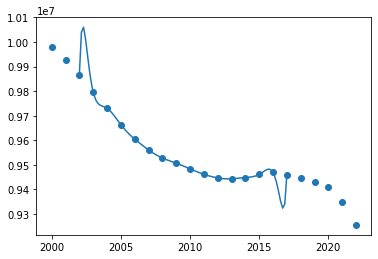

In [4]:
x = nodes[52:68]
f = values[52:68]

interp = Newton(x, f)
t = np.linspace(min(x), max(x), 100)
plt.plot(t, interp(t))

plt.scatter(nodes[50:73], values[50:73])

### Сплайн-аппроксимация

### Метод наименьших квадратов